In [ ]:
import numpy as np

import matplotlib.pyplot as plt 

from keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist, cifar10

%matplotlib inline

In [ ]:
(cifar_train, _), (cifar_test, _) = cifar10.load_data()

size = 32
channel = 3
# scaling input data
cifar_train = cifar_train / 255
cifar_test = cifar_test / 255

# Adding noise mean = 0, std = 0.3
noise = 0.3
cifar_train_noise = cifar_train + noise * np.random.normal(0, 0.3, size=cifar_train.shape) 
cifar_test_noise = cifar_test + noise * np.random.normal(0, 0.3, size=cifar_test.shape)

cifar_train_noise = np.clip(cifar_train_noise, 0, 1)
cifar_test_noise = np.clip(cifar_test_noise, 0, 1)

170508288/170498071 [==============================] - 3s 0us/step


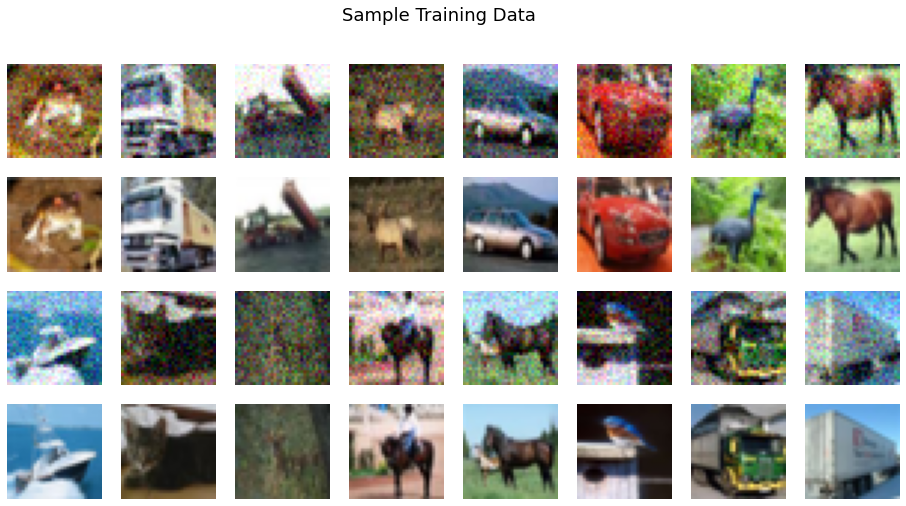

In [ ]:
# Visualize few training images with their noisy images

rows = 2 # defining no. of rows in figure
cols = 8 # defining no. of colums in figure

f = plt.figure(figsize=(2*cols,2*rows*2)) # defining a figure 

for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_train_noise[i*cols + j]) 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_train[i*cols + j]) 
        plt.axis("off")
        
f.suptitle("Sample Training Data",fontsize=18)
plt.savefig("Cifar-trian.png")

plt.show()


In [ ]:
from keras.layers import Conv2DTranspose, BatchNormalization, add, LeakyReLU
from tensorflow.keras.optimizers import Adam

In [ ]:
# Encoder 
inputs = Input(shape=(size,size,channel))

x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.3)(x)
skip = Conv2D(32, 3, padding='same')(x)         # skip connection for decoder
x = LeakyReLU()(skip)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.3)(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPool2D()(x)

# Decoder
x = Conv2DTranspose(128, 3,activation='relu',strides=(2,2), padding='same')(encoded)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Conv2DTranspose(32, 3, activation='relu',strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Conv2DTranspose(32, 3, padding='same')(x)
x = add([x,skip])                                   # adding skip connection from encoding
x = LeakyReLU()(x)
x = BatchNormalization()(x)
decoded = Conv2DTranspose(3, 3, activation='sigmoid',strides=(2,2), padding='same')(x)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy')
autoencoder.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 32, 32, 32)   896         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 32, 32, 32)  128         ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 16, 16, 32)  0           ['batch_normalization_6[0][

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Training
epochs = 15
batch_size = 256

history = autoencoder.fit(cifar_train_noise,
                cifar_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(cifar_test_noise, cifar_test)
               )


Epoch 1/15
196/196 [==============================] - 14s 61ms/step - loss: 0.5740 - val_loss: 0.6163
Epoch 2/15
196/196 [==============================] - 11s 58ms/step - loss: 0.5585 - val_loss: 0.5791
Epoch 3/15
196/196 [==============================] - 11s 57ms/step - loss: 0.5570 - val_loss: 0.5601
Epoch 4/15
196/196 [==============================] - 11s 58ms/step - loss: 0.5563 - val_loss: 0.5580
Epoch 5/15
196/196 [==============================] - 11s 58ms/step - loss: 0.5559 - val_loss: 0.5574
Epoch 6/15
196/196 [==============================] - 11s 58ms/step - loss: 0.5556 - val_loss: 0.5556
Epoch 7/15
196/196 [==============================] - 11s 59ms/step - loss: 0.5553 - val_loss: 0.5552
Epoch 8/15
196/196 [==============================] - 12s 59ms/step - loss: 0.5552 - val_loss: 0.5560
Epoch 9/15
196/196 [==============================] - 11s 58ms/step - loss: 0.5550 - val_loss: 0.5543
Epoch 10/15
196/196 [==============================] - 11s 57ms/step - loss: 0.554

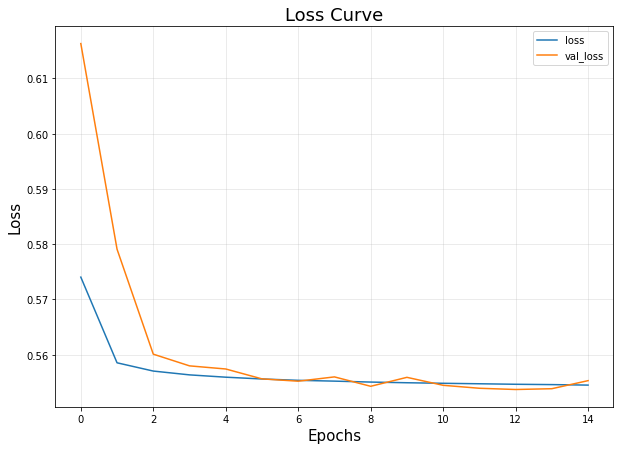

In [ ]:
# Defining Figure
f = plt.figure(figsize=(10,7))
f.add_subplot()

#Adding Subplot
plt.plot(history.epoch, history.history['loss'], label = "loss") # Loss curve for training set
plt.plot(history.epoch, history.history['val_loss'], label = "val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("Loss_curve_cifar10.png")
plt.show()


In [ ]:
# Select few random test images
num_imgs = 48
np.random.seed(0)
rand = np.random.randint(1, cifar_test_noise.shape[0]-48) 

cifar_test_images = cifar_test_noise[rand:rand+num_imgs] # slicing
cifar_test_desoided = autoencoder.predict(cifar_test_images) # predict

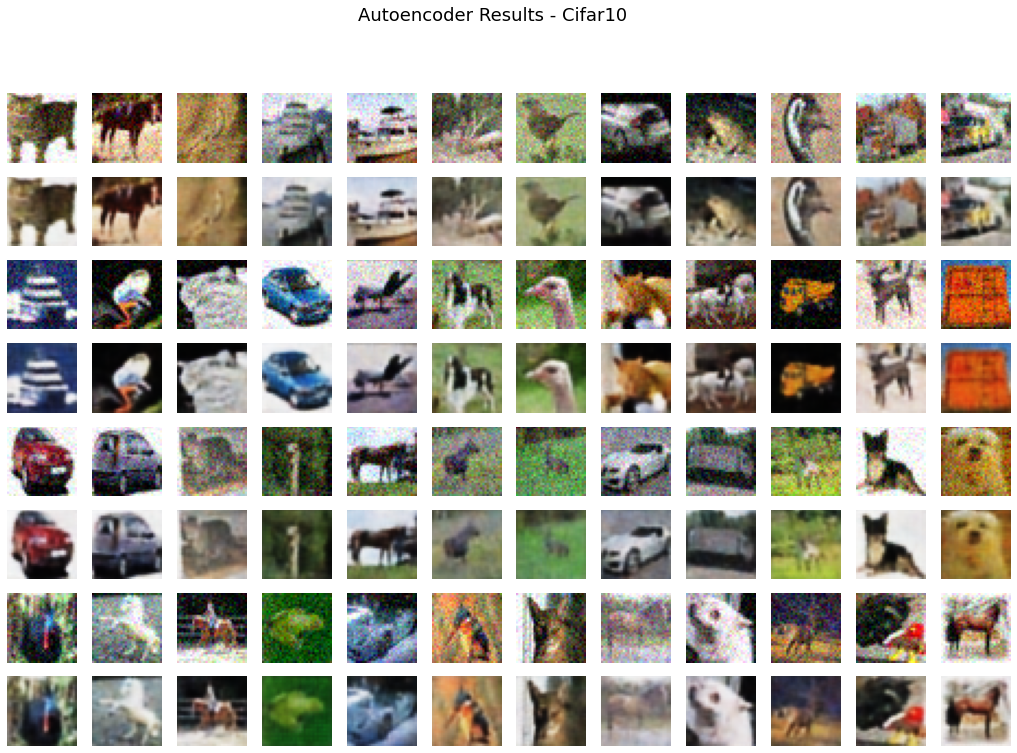

In [ ]:
# Visualize test images with their denoised images

rows = 4 # defining no. of rows in figure
cols = 12 # defining no. of colums in figure
cell_size = 1.5
f = plt.figure(figsize=(cell_size*cols,cell_size*rows*2)) # defining a figure 
f.tight_layout()
for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_test_images[i*cols + j]) 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_test_desoided[i*cols + j]) 
        plt.axis("off")

f.suptitle("Autoencoder Results - Cifar10",fontsize=18)
plt.savefig("test_results_cifar10.png")

plt.show()